# Chatbox for COVID-19 help etc. 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalMaxPool1D, Flatten, Embedding, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Importing data

In [2]:
with open('./data/conversations.json') as f:
    data = json.load(f)

In [3]:
tags=[]
patternss=[]
responses={}
for intent in data['intents']:
    responses[intent['tag']]=intent['responses']
    for patterns in intent['patterns']:
        patternss.append(patterns)
        tags.append(intent['tag'])
    

In [4]:
data = pd.DataFrame({'patterns':patternss, 'tag':tags})

In [5]:
data

,patterns,tag
0,Can my friends visit me?,quarantine_visits
1,quarintine visits,quarantine_visits
2,visiting during quarintine,quarantine_visits
3,meet others during quarintine,quarantine_visits
4,Can someone come see me during quarantine?,quarantine_visits
...,...,...
752,report of lung,lungs
753,lungs report,lungs
754,please check my lungs,lungs
755,can you check my lung report,lungs


In [6]:
# randomly shuffle the data
data = data.sample(frac=1)
data

,patterns,tag
370,I'd like a respirator,masks_availability
282,can I go to grocery stores,shopping_groceries
553,I traveled to Italy recently. What do I do?,symptoms
358,everything is horrible,about_hate
700,Do my test results come in the mail?,testing_results
...,...,...
395,how do I get screened?,testing_locations
92,Where did the coronavirus come from?,covid_description
588,Is there a vaccine for corona virus,treatment_vaccine
285,Effective cleaning and hand washing techqniques,prevention_howto_wash_hands


# Pre-processing

In [7]:
#remove punctuation and convert to lower case
import string
data['patterns'] = data['patterns'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data['patterns'] = data['patterns'].apply(lambda x: x.lower())
data

,patterns,tag
370,id like a respirator,masks_availability
282,can i go to grocery stores,shopping_groceries
553,i traveled to italy recently what do i do,symptoms
358,everything is horrible,about_hate
700,do my test results come in the mail,testing_results
...,...,...
395,how do i get screened,testing_locations
92,where did the coronavirus come from,covid_description
588,is there a vaccine for corona virus,treatment_vaccine
285,effective cleaning and hand washing techqniques,prevention_howto_wash_hands


In [8]:
# tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
x_train = tokenizer.texts_to_sequences(data['patterns'])

# add padding to the data
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encode the tags
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(data['tag'])
y_train = encoder.fit_transform(data['tag'])


In [9]:
input_shape1 = x_train.shape[1]
input_shape1

23

In [10]:
vocab_size = len(tokenizer.word_index)
vocab_size

658

In [11]:
output_size = encoder.classes_.shape[0]
output_size

45

# Neural Network

In [12]:
i = Input(shape=(input_shape1,))
x = Embedding(vocab_size+1, 10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_size, activation='softmax')(x)
model = Model(i, x)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# train the model
# train = model.fit(x_train, y_train, epochs=200, batch_size=64)
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
24/24 [==============================] - 1s 4ms/step - loss: 3.7724 - accuracy: 0.0766
Epoch 2/200
24/24 [==============================] - 0s 4ms/step - loss: 3.5963 - accuracy: 0.0766
Epoch 3/200
24/24 [==============================] - 0s 4ms/step - loss: 3.5043 - accuracy: 0.0872
Epoch 4/200
24/24 [==============================] - 0s 4ms/step - loss: 3.4866 - accuracy: 0.1004
Epoch 5/200
24/24 [==============================] - 0s 3ms/step - loss: 3.4649 - accuracy: 0.1004
Epoch 6/200
24/24 [==============================] - 0s 4ms/step - loss: 3.4411 - accuracy: 0.1004
Epoch 7/200
24/24 [==============================] - 0s 4ms/step - loss: 3.4016 - accuracy: 0.1044
Epoch 8/200
24/24 [==============================] - 0s 4ms/step - loss: 3.3411 - accuracy: 0.1162
Epoch 9/200
24/24 [==============================] - 0s 4ms/step - loss: 3.2557 - accuracy: 0.1651
Epoch 10/200
24/24 [==============================] - 0s 5ms/step - loss: 3.1487 - accuracy: 0.1876
Epoch 11/

In [14]:
#save the model
model.save('../Models/chatbox_model.h5')

In [15]:
import pickle
# save the tokenizer, label encoder , response dictionary and input_shape in a single file in the form of a dictionary
pickle.dump({'encoder': encoder, 'tokenizer': tokenizer, 'responses': responses, 'input_shape': input_shape1}, open('chatbox_model.pkl', 'wb'))


# Model Analysis

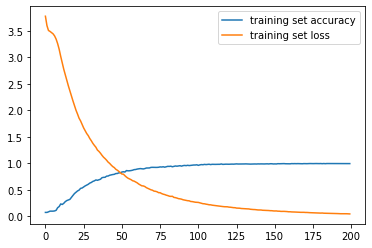

In [16]:
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

# Testing

In [17]:
import random


while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape1)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = encoder.inverse_transform([output])[0]
  final_output = random.choice(responses[response_tag])
  print("Covid 19- Chat bot : ",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

Covid 19- Chat bot :  What's up
Covid 19- Chat bot :  Hello
Covid 19- Chat bot :  What's up
Covid 19- Chat bot :  Hey
Covid 19- Chat bot :  One must stay isolated and not come in contact with others for atleast 14 days. Please refer to this website for information on how to self-quarantine: https://www.cdc.gov/coronavirus/2019-ncov/your-health/quarantine-isolation.html
Covid 19- Chat bot :  Bye! Come back again soon.
